In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
file_path = 'connect4_dataset_new.csv'
dataset = pd.read_csv(file_path)

dataset.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.31,0.32,1.1,1.2,0.33,-1.1,0.34,0.35,0.36,0.37
0,0,0,0,1,0,0,0,0,0,0,...,1,-1,1,-1,1,1,-1,-1,-1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,-1,0,1,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,-1,0,0,1,0
3,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,1,-1,1,1,-1,1,0
4,0,0,0,0,0,0,0,0,0,-1,...,1,1,1,-1,1,-1,-1,-1,-1,0


In [3]:
# Preprocess data
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

valid_indices = (y >= 0) & (y <= 6)
X = X[valid_indices]
y = y[valid_indices]

y = to_categorical(y, num_classes=7)

X = X.reshape(-1, 6, 7, 1)

X_flat = X.reshape(X.shape[0], -1)

X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

In [4]:
# Learning curve computation
def compute_learning_curve(model, X_train, X_test, y_train, y_test):
    train_sizes = [5000, 10000, 20000, 40000, 60000, 80000, 100000]
    train_accuracies = []
    test_accuracies = []

    for size in train_sizes:
        X_train_subset = X_train[:size]
        y_train_subset = y_train[:size]

        model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=64, verbose=0)

        train_accuracy = model.evaluate(X_train_subset, y_train_subset, verbose=0)[1]
        test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_sizes, train_accuracies, test_accuracies

In [5]:
# Build and Train Model
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

mlp_model = Sequential([
    Dense(128, activation='tanh', input_shape=(42,)),
    Dropout(0.6),
    Dense(256, activation='tanh', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(256, activation='tanh', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(7, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
mlp_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

mlp_sizes, mlp_train_acc, mlp_test_acc = compute_learning_curve(mlp_model, X_train_flat, X_test_flat, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Evaluate the MLP model on the test set
test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6933 - loss: 1.0614
Test Accuracy: 0.70


In [7]:
mlp_model.save("connect4_mlp_model.h5")

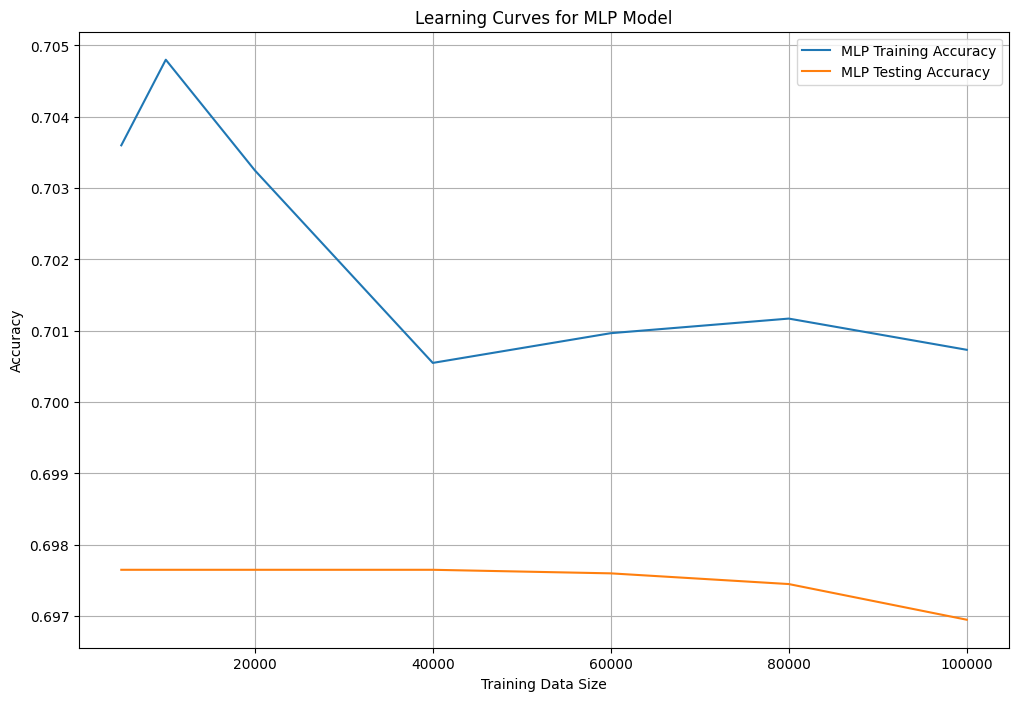

In [8]:
# Plot learning curves
plt.figure(figsize=(12, 8))
plt.plot(mlp_sizes, mlp_train_acc, label="MLP Training Accuracy")
plt.plot(mlp_sizes, mlp_test_acc, label="MLP Testing Accuracy")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves for MLP Model")
plt.legend()
plt.grid()
plt.show()